# Exploring Multi-Armed Bandit Problem: Epsilon-Greedy, Epsilon-Decreasing, UCB, and Thompson Sampling

The multi-armed bandit problem is a classic dilemma in the realm of sequential decision-making under uncertainty. It finds applications in a wide array of domains, from recommendation systems and clinical trials to online advertising and resource allocation. At its core, the problem revolves around efficiently allocating resources (such as time, money, or clicks) to a set of options, referred to as "arms" in order to maximize cumulative rewards.

## What is the Multi-Armed Bandit Problem?

The multi-armed bandit problem embodies several key characteristics:

### Stateless:
In the context of this problem, we operate in a stateless environment. This means that each decision made at any given time does not depend on prior decisions or states. It's as if we are pulling levers on a row of slot machines (the "bandits") independently.

### No Change of Environment:
Unlike some decision-making scenarios where the environment can change or adapt over time, the multi-armed bandit problem (in general) assumes a static environment. The probabilities of receiving rewards from each arm do not change during the course of the problem. Thus, the challenge lies in discovering the arm that consistently yields the highest average reward.

### Objective:
The primary objective in the multi-armed bandit problem is to identify and exploit the arm that, on average, produces the largest reward. This objective necessitates a careful balance between exploring the arms to gather information and exploiting the current best-known arm to maximize rewards.

## Two Kinds of Environments Explored in the Context of the Multi-Armed Bandit Problem

There are two two fundamental types of reward environments we can solve as the Multi-Armed Bandit Problem.

### Discrete Reward:
In the discrete reward environment, each arm provides rewards from a finite set of possibilities. This discrete nature simplifies the problem to some extent but still presents interesting challenges in optimizing decision-making. An example of this type of reward is a click by a viewer of Internet Advertisement, i.e. 1 if a user clicks it while 0 if he/she does not.

### Continuous Reward:
The continuous reward environment extends the problem to situations where arms yield rewards from a continuous range of values. This adds complexity, as decisions now involve real-valued rewards and demand more sophisticated strategies. An example of this type of reward is a a user's level of interaction or satisfaction with the recommended content by a recommendation system. It will be high (continuous measurement) when the recommended contents match with the user's interests and increase the engagement. 

In this Jupyter notebook, we delve into the multi-armed bandit problem by focusing primarily on the discrete reward environment, which is a fundamental and commonly encountered scenario. 

## Algorithms We Will Learn Through This Notebook

To tackle the multi-armed bandit problem effectively, we will learn several well-established algorithms, each with its own approach to balancing exploration and exploitation. These algorithms include:

### Epsilon Greedy Algorithm:
The epsilon-greedy algorithm is a straightforward approach that balances exploration (randomly choosing an arm) and exploitation (choosing the arm with the highest estimated reward). It introduces an exploration parameter, epsilon $\epsilon$, which governs the trade-off between these two aspects.

### Epsilon Decreasing:
Building upon the epsilon-greedy algorithm, epsilon-decreasing gradually reduces the exploration rate over time. This strategy allows for more exploration in the initial stages and transitions toward greater exploitation as the algorithm gathers more information.

### Upper Confidence Bound (UCB):
The UCB algorithm calculates an upper confidence bound for each arm's reward estimate, choosing the arm with the highest upper bound. This technique leverages uncertainty in reward estimates to guide exploration while favoring arms that are likely to be optimal.

### Thompson Sampling:
Thompson Sampling is a probabilistic algorithm that models each arm's reward distribution. It samples from these distributions to make decisions, naturally balancing exploration and exploitation by adapting to the observed rewards.

Throughout this notebook, our primary focus will be on these algorithms applied to the discrete reward environment. By the end, you will have a comprehensive understanding of how to approach and address this intriguing problem in the context of discrete rewards. So let's start!


___

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Parameters
fontsize = 15
num_trial = 1000
num_ite = 100
num_arm = 10
arm_labels_str =  [str(x) for x in range(num_arm)]


## Prepare a discrete reward multi-armed bandit environment

To begin, we set up a discrete reward multi-armed bandit environment. In this environment, we create ten arms, each with a mean reward probability that is uniformly sampled from the range [0, 1]. Each arm yields a reward of 1 with a probability equal to its mean reward probability and a reward of 0 with a probability of 1 minus the mean probability.


The best reward probability is 0.89
The mean reward probability is 0.44


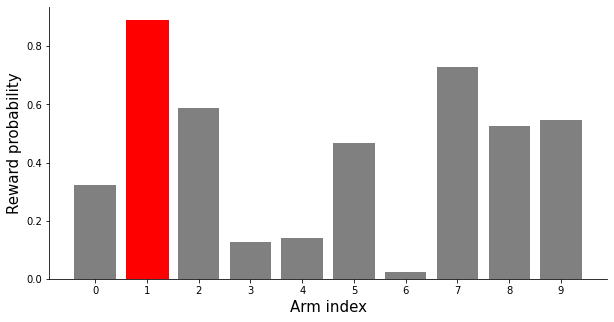

In [2]:
# Initialize the bandit environment
num_arms = 10  # Number of arms
random_seed = 2023
np.random.seed(random_seed)

# Generate random reward probabilities for each arm
reward_probs = np.random.uniform(0, 1, num_arms)

# Find the index of the arm with the highest reward probability
best_arm_index = np.argmax(reward_probs)

# Create labels for each arm
arm_labels = [str(x) for x in range(num_arms)]

# Create a bar plot to visualize the reward probabilities of each arm
plt.figure(figsize=(10, 5))
barlist = plt.bar(arm_labels, reward_probs, color='gray')
barlist[best_arm_index].set_color('r')
plt.xlabel('Arm index', fontsize=fontsize)
plt.ylabel('Reward probability', fontsize=fontsize)

# Print the best and mean reward probabilities
best_reward_prob = reward_probs[best_arm_index]
mean_reward_prob = np.mean(reward_probs)
print(f"The best reward probability is {np.round(best_reward_prob, 2)}")
print(f"The mean reward probability is {np.round(mean_reward_prob, 2)}")


The above plot visualizes the mean probabilities associated with each arm. If we keep choosing arm1, we will receive a reward in 89% of the trials and this is the best performance we can achieve. 

If we randomly explore an arm in each trial, what will be the probability of obtaining a reward? This will serve as our baseline performance against which we can later compare the performance of other algorithms. Let's implement this algorithm. We will also implement utility functions for running simulations.


In [3]:
class MultiArmedBandit:
    def __init__(self, num_arm, reward_probs):
        # Initialize the multi-armed bandit with the number of arms, reward probabilities, and an optional parameter.
        self.num_arm = num_arm
        self.reward_probs = reward_probs
                
    def run_iteration(self, iters, time_steps):
        rewards_hists = []
        explored_cnts = []

        # Run multi-armed bandit simulation for a specified number of iterations.
        for i in range(iters):
            # Store reward history and total explored count of each arm for each iteration i.
            reward_hist, explored_cnt = self.run_episode(time_steps)
            rewards_hists.append(reward_hist)
            explored_cnts.append(explored_cnt)            
        
        # Compute the average and standard deviation over iterations.
        avg_reward_hist = np.mean(rewards_hists, axis=0)
        std_reward_hist = np.std(rewards_hists, axis=0)
        avg_explored_cnt = np.mean(explored_cnts, axis=0)
        std_explored_cnt = np.std(explored_cnts, axis=0)

        return avg_reward_hist, std_reward_hist, avg_explored_cnt, std_explored_cnt
        
    def run_episode(self, time_steps):
        rewards = []
        exp_reward_prob = np.zeros(self.num_arm)
        explored_cnt = np.zeros(self.num_arm)
        
        # Perform multiple trials in a single episode.
        for trial in range(time_steps):
            arm, reward = self.step()
            exp_reward_prob, explored_cnt = self.update(arm, reward, exp_reward_prob, explored_cnt)
            rewards.append(reward)
        return rewards, explored_cnt

    def step(self):
        # Randomly choose one arm and observe its reward.
        arm = np.random.choice(range(self.num_arm))
        reward = np.random.choice([0, 1], p=[1-self.reward_probs[arm], self.reward_probs[arm]])
        return arm, reward
        
    def update(self, arm, reward, exp_reward_prob, explored_cnt):
        # Update the estimated reward probability for the chosen arm.
        explored_cnt[arm] += 1
        exp_reward_prob[arm] = exp_reward_prob[arm] + (1/explored_cnt[arm] * (reward - exp_reward_prob[arm]))
        return exp_reward_prob, explored_cnt
    
    def plot_algorithm_performance(self, algo, avg_reward_hist, std_reward_hist, avg_explored_cnt, time_steps, best_arm_prob):
        # Create subplots to visualize algorithm performance metrics.
        plt.figure(figsize=(20,5))

        # Plot average reward over time steps.
        plt.subplot(1,3,1)
        plt.plot(list(range(time_steps)), avg_reward_hist, color='b')
        plt.axhline(y=best_arm_prob, color='r')
        plt.ylim([0, 1])
        plt.xlabel('Time steps', fontsize=fontsize)
        plt.ylabel('Avg. reward at each time step', fontsize=fontsize)

        # Plot average reward across all time steps.
        plt.subplot(1,3,2)
        avg_reward = [np.mean(avg_reward_hist), best_arm_prob]
        std_reward = [np.std(avg_reward_hist), 0]
        plt.bar([algo, 'Best'], avg_reward, yerr=std_reward, color='gray')
        plt.ylim([0, 1])
        plt.xticks(fontsize=fontsize)
        plt.ylabel('Avg. reward over time steps', fontsize=fontsize)

        # Plot average explored count for each arm.
        plt.subplot(1,3,3)
        arm_labels =  [str(x) for x in range(self.num_arm)]
        plt.bar(arm_labels, avg_explored_cnt, color='gray')
        plt.xticks(fontsize=fontsize)
        plt.ylabel('Avg. explored trial count', fontsize=fontsize)
        

The "step" function within this class implements a random exploration algorithm. Now, we will conduct 1000 trials across 100 episodes and assess the algorithm's average performance.

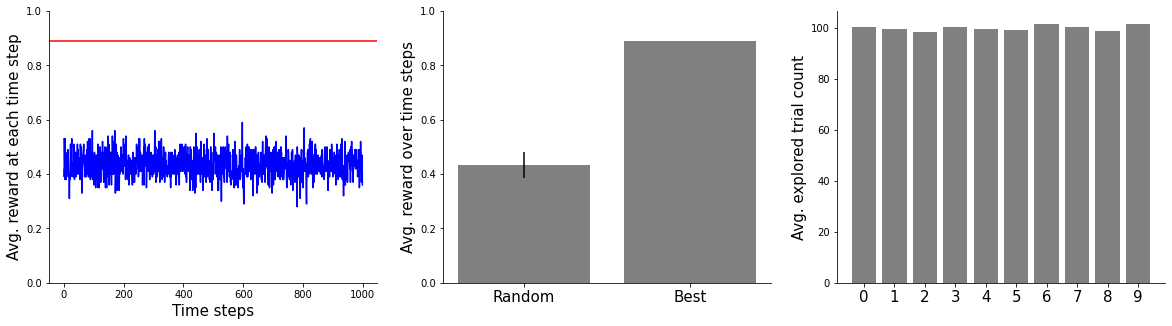

In [4]:
# Baseline: Random Exploration
re = MultiArmedBandit(num_arm, reward_probs)

# Run random exploration simulation
avg_rewards_re, std_rewards_re, avg_explored_cnt_re, std_explored_cnt_re = re.run_iteration(num_ite, num_trial)

# Plot random exploration performance
re.plot_algorithm_performance('Random', avg_rewards_re, std_rewards_re, avg_explored_cnt_re, num_trial, reward_probs[best_arm_index])


The average reward probility of random exploration is about 0.44, which is the mean reward probability across all arms. From next section, we will explore different algorithms to solve the multi-armed bandit problem. We would like to make sure that the average reward probability of those algorithms is better than this value.


## Epsilon Greedy Algorithm: Choose the most greedy option with probability 1-epsilon and choose randomly with probability epsilon

The multi-armed bandit problem poses a challenge: how can we maximize our rewards when faced with multiple options, each with an unknown probability of success? One straightforward approach is to try each option once and then focus on those that seem most promising based on our initial observations. For example, if we receive rewards [0, 0, 0, 0, 0, 1, 1, 1, 1, 1] from arms 0 to 9 in our first attempts, it might seem logical to randomly select one of the last 5 arms for subsequent trials. 

However, there's a catch. By doing this, we risk ignoring the first 5 arms, which yielded no rewards in the initial round. Their expected reward probabilities remain at zero, while the last 5 arms have higher expected probabilities due to their early successes. In such cases, we may miss out on arms with potentially higher rewards, like arm1 in our example.

The Epsilon Greedy Algorithm offers a solution by introducing a hyperparameter called epsilon (ε). This parameter balances exploitation (choosing the arm with the highest expected reward) and exploration (trying different arms to discover their potential). 

Let's dive into implementing the Epsilon Greedy Algorithm.

In [5]:
class EpsilonGreedy(MultiArmedBandit):
    def __init__(self, num_arm, reward_probs, epsilon):
        # Initialize the Epsilon Greedy algorithm with the number of arms, reward probabilities, and epsilon.
        super().__init__(num_arm, reward_probs)
        self.epsilon = epsilon

    def run_episode(self, time_steps):
        rewards = []
        exp_reward_prob = np.zeros(self.num_arm)
        explored_cnt = np.zeros(self.num_arm)

        # Perform multiple trials in a single episode.
        for trial in range(time_steps):
            # Use exp_reward_prob to decide the next arm.
            arm, reward = self.step(exp_reward_prob)
            exp_reward_prob, explored_cnt = self.update(arm, reward, exp_reward_prob, explored_cnt)
            rewards.append(reward)
        return rewards, explored_cnt

    def step(self, exp_reward_prob):
        p = np.random.random()  # Generate a random number in the range (0, 1).
        if p < self.epsilon:  # Exploration: Choose a random arm.
            arm = np.random.choice(self.num_arm)
        else:  # Exploitation: Choose the arm with the highest expected reward (break ties randomly).
            greedy_arm_indices = np.where(exp_reward_prob == exp_reward_prob.max())[0]
            arm = np.random.choice(greedy_arm_indices)
        reward = np.random.choice([0, 1], p=[1 - self.reward_probs[arm], self.reward_probs[arm]])
        return arm, reward


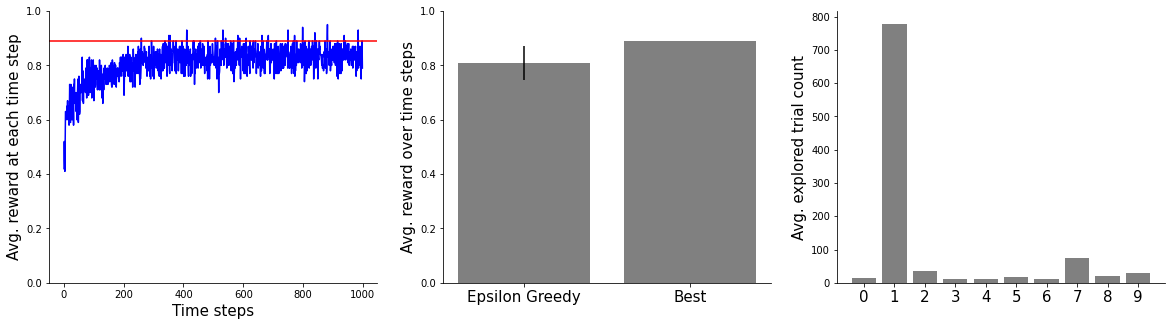

In [6]:
epsilon = 0.1
eg = EpsilonGreedy(num_arm, reward_probs, epsilon)
avg_rewards_eg, std_rewards_eg, avg_explored_cnt_eg, std_explored_cnt_eg = eg.run_iteration(num_ite, num_trial)
eg.plot_algorithm_performance('Epsilon Greedy', avg_rewards_eg, std_rewards_eg, avg_explored_cnt_eg, num_trial, reward_probs[best_arm_index])


As the number of time steps increases, we observe a gradual rise in the average reward, which eventually stabilizes around the highest achievable reward value. This suggests that the Epsilon Greedy algorithm effectively identifies the best-performing arm among the ten available options. This trend is clearly evident in the right panel, where the count of explored trials is maximized for the arm with the highest reward probability (i.e. arm1). Furthermore, as we see in the middle plot, the average reward over time significantly outperforms that of the random algorithm, averaging around 0.44.

In this simulation, we set the epsilon value to 0.1. However, choosing the optimal hyperparameter value for epsilon is crucial. To address this, we will conduct simulations using various epsilon values to find the most effective choice.

The best parameter set is 0.1 with avg.reward=0.811


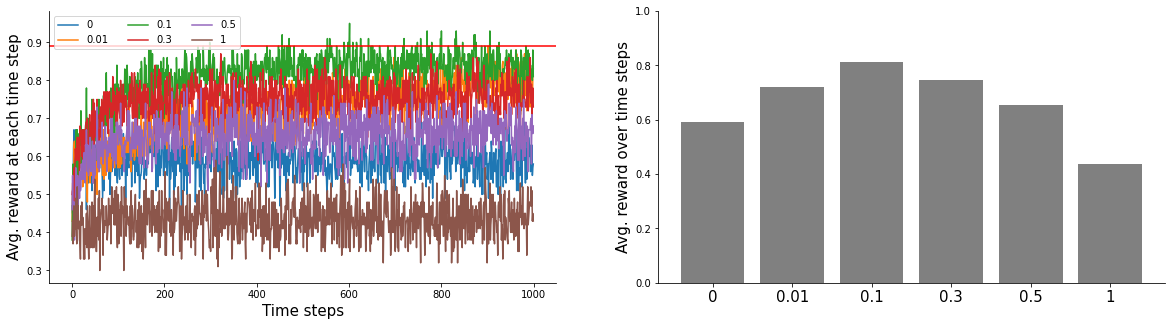

In [7]:
epsilons = [0, 0.01, 0.1, 0.3, 0.5, 1]

# Initialize lists to store results.
avg_rewards_hist_eg = []
avg_rewards_overall_eg = []

# Loop through different epsilon values.
for epsilon in epsilons:
    eg = EpsilonGreedy(num_arm, reward_probs, epsilon)
    avg_rewards_eg, std_rewards_eg, avg_explored_cnt_eg, std_explored_cnt_eg = eg.run_iteration(num_ite, num_trial)
    avg_rewards_hist_eg.append(avg_rewards_eg)
    avg_rewards_overall_eg.append(np.mean(avg_rewards_eg))

# Create a figure for visualization.
plt.figure(figsize=(20, 5))

# Plot average reward over time steps for each epsilon value.
plt.subplot(1, 2, 1)
for i in range(len(epsilons)):
    plt.plot(list(range(num_trial)), avg_rewards_hist_eg[i], label=epsilons[i])
plt.legend(ncol=3)
plt.axhline(y=reward_probs[best_arm_index], color='r')
plt.xlabel('Time steps', fontsize=fontsize)
plt.ylabel('Avg. reward at each time step', fontsize=fontsize)

# Plot average reward across all time steps for each epsilon value.
plt.subplot(1, 2, 2)
epsilons_str = [str(x) for x in epsilons]
plt.bar(epsilons_str, avg_rewards_overall_eg, color='gray')
plt.ylim([0, 1])
plt.xticks(fontsize=fontsize)
plt.ylabel('Avg. reward over time steps', fontsize=fontsize)

# Identify the best-performing epsilon value.
best_param_index = np.where(avg_rewards_overall_eg == np.max(avg_rewards_overall_eg))[0][0]
print(f"The best parameter set is {epsilons_str[best_param_index]} with avg.reward={np.round(avg_rewards_overall_eg[best_param_index], 3)}")


In fact, an epsilon value of 0.1 yielded the highest average reward at each time step and over time steps. In the context of the Epsilon Greedy algorithm, an epsilon of 1 corresponds to pure random exploration, while an epsilon of 0 represents a purely greedy approach. Our exploration of different epsilon values serves the purpose of determining the optimal balance between exploitation and exploration.

Another noteworthy observation is that there remains a gap in the average reward between the best-performing Epsilon Greedy approach and the best arm reward. This discrepancy arises because the Epsilon Greedy algorithm continues to explore with a probability of epsilon, even after identifying the optimal arm. Ideally, we would prefer higher epsilon values at the beginning to promote exploration and gradually reduce epsilon's value to emphasize exploitation and maximize our rewards. The Epsilon Decreasing algorithm, which we will learn next, offers a solution to address this issue.

## Epsilon Decreasing Algorithm: Gradually reducing exploration


The Epsilon Decreasing algorithm introduces an additional hyperparameter, alpha $\alpha$, which takes a value within the range 0 < $\alpha$ < 1. 

$\alpha$ is used to scale epsilon at each time step, gradually reducing its value over time. This approach controls a balance between exploration and exploitation, emphasizing exploration early on and favoring exploitation as we learn more.

Let's see the implementation of this algorithm.

In [8]:
class EpsilonDecreasing(MultiArmedBandit):
    def __init__(self, num_arm, reward_probs, epsilon, alpha):
        # Initialize the Epsilon Decreasing algorithm with the number of arms, reward probabilities, epsilon,
        # and alpha for gradual epsilon reduction.
        super().__init__(num_arm, reward_probs)
        self.epsilon = epsilon  # Original value of epsilon
        self.epsilon_update = epsilon  # Gradually reduce the value of this epsilon
        self.alpha = alpha
    
    def run_episode(self, time_steps):
        rewards = []
        exp_reward_prob = np.zeros(self.num_arm)
        explored_cnt = np.zeros(self.num_arm)
        self.epsilon_update = self.epsilon  # Initialize the value of epsilon at the beginning of each episode
        
        # Draw an arm, observe reward, and update predictions for a specified number of trials.
        for trial in range(time_steps):
            # Use exp_reward_prob to decide the next arm.
            arm, reward = self.step(exp_reward_prob)
            exp_reward_prob, explored_cnt = self.update(arm, reward, exp_reward_prob, explored_cnt)
            rewards.append(reward)
        return rewards, explored_cnt
    
    def step(self, exp_reward_prob):
        p = np.random.random()  # Generate a random number in the range (0, 1).
        if p < self.epsilon_update:  # Exploration: Choose a random arm.
            arm = np.random.choice(self.num_arm)
        else:  # Exploitation: Choose the arm with the highest expected reward (break ties randomly).
            greedy_arm_indices = np.where(exp_reward_prob == exp_reward_prob.max())[0]
            arm = np.random.choice(greedy_arm_indices)
        
        # Generate a reward for the chosen arm.
        reward = np.random.choice([0, 1], p=[1 - self.reward_probs[arm], self.reward_probs[arm]])
        
        # Reduce the value of epsilon at each time step using alpha.
        self.epsilon_update = self.alpha * self.epsilon_update
        return arm, reward


Now, let's explore the behavior of the Epsilon Decreasing algorithm by examining different combinations of epsilon and alpha values. As we covered, epsilon determines the initial exploration rate, while alpha dictates the rate at which epsilon decreases over time.
Let's visualize how epsilon changes under different epsilon and alpha combinations.


Text(0, 0.5, 'Epsilon')

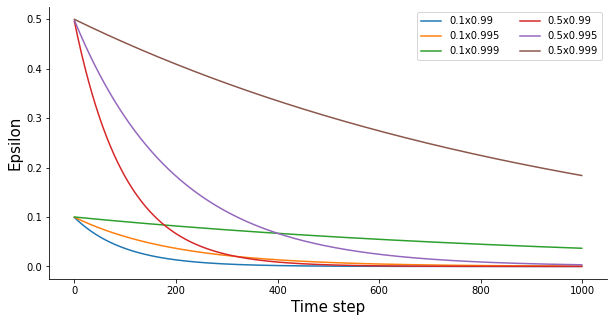

In [9]:
epsilons = [0.1, 0.5]
alphas = [0.99, 0.995, 0.999]
epsilons_hist = []
param_labels = []

for epsilon in epsilons:
    for alpha in alphas:
        epsilon_hist = []
        epsilon_updated = epsilon
        for i in range(num_trial):
            epsilon_updated = epsilon_updated * alpha
            epsilon_hist.append(epsilon_updated)
        epsilons_hist.append(epsilon_hist)
        param_labels.append(f"{epsilon}x{alpha}")

plt.figure(figsize=(10,5))
for i in range(len(param_labels)):
    plt.plot(list(range(num_trial)), epsilons_hist[i], label=param_labels[i])
plt.legend(ncol=2)
plt.xlabel('Time step', fontsize=fontsize)
plt.ylabel('Epsilon', fontsize=fontsize)


For instance, consider epsilon=0.1 and alpha=0.99 (depicted by the blue line). Here, the algorithm rapidly transitions towards almost full exploitation after approximately 300 trials because the epsilon value approaches zero. Conversely, if we start with a higher epsilon, such as 0.5, it encourages a more extended period of exploration before eventually converging into a strong exploitation strategy. People tned to use use higher epsilon values with Epsilon Decreasing compared to Epsilon Greedy. This design encourages substantial exploration in the initial phases, gradually shifting towards increased exploitation as the number of trials increases.

So what is the best combination of epsilon and alpha in this setup? As we did for epsilon greedy, let's run hypperparameter search.

The best parameter set is 0.5x0.99 with avg.reward=0.846


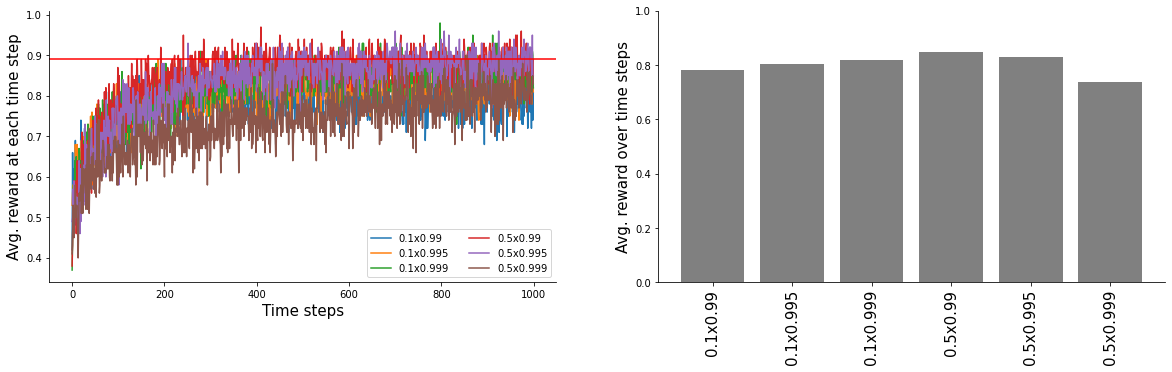

In [10]:
epsilons = [0.1, 0.5]
alphas = [0.99, 0.995, 0.999]
avg_rewards_hist_ed = []  # To store average rewards over time for different combinations.
avg_rewards_overall_ed = []  # To store overall average rewards for different combinations.

# Run simulations for all combinations of epsilon x alpha.
for epsilon in epsilons:
    for alpha in alphas:
        ed = EpsilonDecreasing(num_arm, reward_probs, epsilon, alpha)
        avg_rewards_ed, std_rewards_ed, avg_explored_cnt_ed, std_explored_cnt_ed = ed.run_iteration(num_ite, num_trial)
        avg_rewards_hist_ed.append(avg_rewards_ed)
        avg_rewards_overall_ed.append(np.mean(avg_rewards_ed))
    
# Create a figure for visualization.
plt.figure(figsize=(20, 5))

# Plot average reward over time steps for each combination of epsilon x alpha.
plt.subplot(1, 2, 1)
labels = []
plot_index = 0
for i in range(len(epsilons)):
    for j in range(len(alphas)):
        plt.plot(list(range(num_trial)), avg_rewards_hist_ed[plot_index], label=f"{epsilons[i]}x{alphas[j]}")
        labels.append(f"{epsilons[i]}x{alphas[j]}")
        plot_index += 1
        
plt.legend(ncol=2)
plt.axhline(y=reward_probs[best_arm_index], color='r')
plt.xlabel('Time steps', fontsize=fontsize)
plt.ylabel('Avg. reward at each time step', fontsize=fontsize)

# Plot overall average reward for each combination of epsilon x alpha.
plt.subplot(1, 2, 2)
plt.bar(labels, avg_rewards_overall_ed, color='gray')
plt.ylim([0, 1])
plt.xticks(fontsize=fontsize, rotation=90)
plt.ylabel('Avg. reward over time steps', fontsize=fontsize)

# Identify the best-performing combination of epsilon x alpha.
best_param_index = np.where(avg_rewards_overall_ed == np.max(avg_rewards_overall_ed))[0][0]
print(f"The best parameter set is {labels[best_param_index]} with avg.reward={np.round(avg_rewards_overall_ed[best_param_index], 3)}")


In this case, the parameter set {epsilon=0.5 and alpha=0.99} is the best-performing configuration (although this outcome may slightly vary depending on the simulated values). As expected, the average reward achieved with this optimal parameter set outperforms that of the Epsilon Greedy algorithm (which was about 0.81).

However, it's essential to note that we now have an additional hyperparameter to fine-tune in this algorithm. While Epsilon Decreasing outperforms Epsilon Greedy, optimizing it requires increased computational resources to determine the most suitable hyperparameter values.

## Upper Confidence Bound (UCB): Explore uncertain arms more frequently

So far, we have been randomly choosing arms during exploration trials. However, is this truly an effective strategy? Ideally, we would like to explore the options where we have a higher chance of observing good results rather than wasting time on options that are likely to perform poorly.

The Upper Confidence Bound (UCB) algorithm offers a solution to this problem. Instead of relying on random exploration, UCB prioritizes options with high uncertainty, as these have the potential to yield excellent results. In UCB, there is no clear distinction between exploitation and exploration trials; arms are selected based on the following equation:

$$
\text{UCB}(a) = \text{Q}(a) + \sqrt{\frac{2\ln(t)}{N(a)}}
$$

In this equation, the first term represents the expected mean reward Q(a), while the second term quantifies the uncertainty associated with the option. The variable t represents the total number of trials conducted so far, and N(a) represents the number of times arm a has been selected. The second term in the equation will be relatively large for an arm that has been explored fewer times compared to the total number of trials. This encourages the algorithm to prioritize the exploration of arms with higher uncertainty.

Now, let's implement this algorithm.

In [11]:
class UpperConfidenceBound(MultiArmedBandit):
    def __init__(self, num_arm, reward_probs, c):
        self.num_arm = num_arm
        self.reward_probs = reward_probs
        self.c = c
    
    def run_episode(self, time_steps):
        rewards = []
        exp_reward_prob = np.zeros(self.num_arm)
        explored_cnt = np.zeros(self.num_arm)
        
        # Draw an arm, observe reward, and update predictions for a specified number of time steps
        for trial in range(time_steps):
            # Use exp_reward_prob to decide the next arm
            arm, reward = self.step(exp_reward_prob, explored_cnt, trial)
            exp_reward_prob, explored_cnt = self.update(arm, reward, exp_reward_prob, explored_cnt)
            rewards.append(reward)
        return rewards, explored_cnt
    
    def step(self, exp_reward_prob, explored_cnt, trial):
        if trial < self.num_arm:  # Explore all arms once
            arm = trial
        else:  # UCB
            # ucb = exp_reward_prob + self.c * np.sqrt(np.log(trial + 1) / (explored_cnt + 1))  # Use trial + 1
            ucb = exp_reward_prob + self.c * np.sqrt(np.log(trial) / (explored_cnt))  # Use trial + 1
            best_ucb_arm_indices = np.where(ucb == ucb.max())[0]
            arm = np.random.choice(best_ucb_arm_indices)  # Break a tie randomly
        reward = np.random.choice([0, 1], p=[1 - self.reward_probs[arm], self.reward_probs[arm]])
        return arm, reward
    

Note that in the step function, we initially iterate through all arms once to prevent a zero value in the logarithmic term and division by 0.

The parameter 'c' is a hyperparameter for the UCB algorithm and serves to balance exploitation and exploration. A larger 'c' value leads to more exploration, while 'c=0' corresponds to a purely greedy algorithm.

Let's explore the best hyperparameter 'c'.

The best parameter is 0.5 with avg. reward=0.86


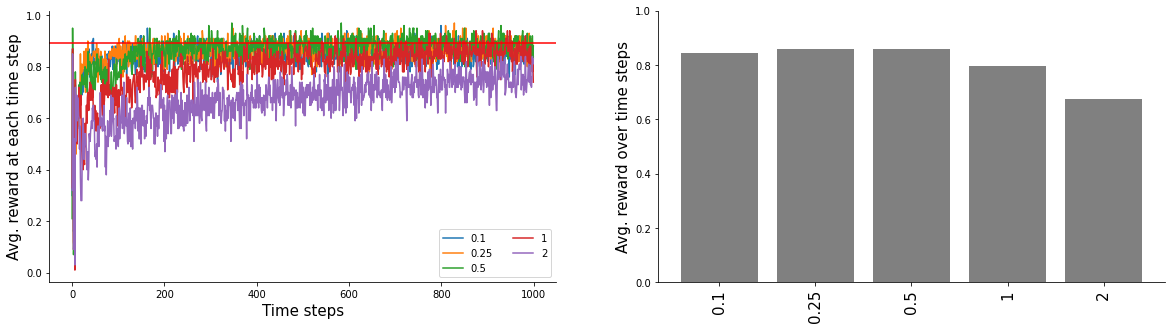

In [12]:
cs = [0.1, 0.25, 0.5, 1, 2]
avg_rewards_hist_ucb = []
avg_rewards_overall_ucb = []

# Run simulation with different value of 'c'
for c in cs:
    ucb = UpperConfidenceBound(num_arm, reward_probs, c)
    avg_rewards_ucb, std_rewards_ucb, avg_explored_cnt_ucb, std_explored_cnt_ucb = ucb.run_iteration(num_ite, num_trial)
    avg_rewards_hist_ucb.append(avg_rewards_ucb)
    avg_rewards_overall_ucb.append(np.mean(avg_rewards_ucb))
    

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
labels = []

# Plot average rewards for each 'c'
for i in range(len(cs)):
    plt.plot(list(range(num_trial)), avg_rewards_hist_ucb[i], label=f"{cs[i]}")
    labels.append(f"{cs[i]}")

plt.legend(ncol=2)
plt.axhline(y=reward_probs[best_arm_index], color='r')
plt.xlabel('Time steps', fontsize=fontsize)
plt.ylabel('Avg. reward at each time step', fontsize=fontsize)

plt.subplot(1, 2, 2)

# Create a bar chart to display overall average rewards for each 'c'
plt.bar(labels, avg_rewards_overall_ucb, color='gray')
plt.ylim([0, 1])
plt.xticks(fontsize=fontsize, rotation=90)
plt.ylabel('Avg. reward over time steps', fontsize=fontsize)

# Find the best parameter based on the highest overall average reward
best_param_index = np.where(avg_rewards_overall_ucb == np.max(avg_rewards_overall_ucb))[0][0]
print(f"The best parameter is {labels[best_param_index]} with avg. reward={np.round(avg_rewards_overall_ucb[best_param_index], 3)}")


With the best parameter, we observe further improvement from epsilon decreasing!

## Thompson sampling: Use Bayesian framework to guide the exploitation and exploration

Lastly, I will introduce an algorithm using Bayesian framework - Thompson sampling. Thompson sampling balances the exploration of uncertain options and the exploitation of known high-reward options using Bayesian posterior. It updates a probability distribution over the reward probabilities of different arms (posterior) and uses this distribution to make decisions.

Here's a high-level overview of how Thompson Sampling works:

1. Initialization: Initially, the algorithm assigns a reward probability distribution (often a Beta distribution) to each arm. The distribution represents the uncertainty or belief about the true underlying reward probability of each arm.

2. Arm Selection: For each time step, the algorithm samples a value from each reward probability distribution. These sampled values represent hypothetical reward probabilities for each arm.

3. Exploration vs. Exploitation: Thompson Sampling then selects the arm with the highest sampled value, thus favoring actions with a higher probability of yielding a high reward. However, since the sampled values are probabilistic, Thompson Sampling naturally explores other options as well.

4. Updating Probability Distributions: After observing the actual reward of the chosen arm, Thompson Sampling updates the probability distribution for that arm. This update incorporates the observed reward and adjusts the belief about the arm's true reward probability.

5. Repeat: The algorithm repeats steps 2-4 for a predefined number of rounds or until a stopping criterion is met.

Let's implement and test this algorithm.

In [13]:
class ThompsonSampling(MultiArmedBandit):
    def __init__(self, num_arm, reward_probs, prior=None):
        # Initialize Thompson Sampling with the number of arms, reward probabilities, and an optional prior
        self.num_arm = num_arm
        self.reward_probs = reward_probs
        self.prior = prior
    
    def run_episode(self, time_steps):
        rewards = []
        
        # Initialize success-failure counts for each arm
        if self.prior is None:
            succ_fail = np.zeros([self.num_arm, 2])
        else:
            succ_fail = [x[:] for x in self.prior]  # Deep copy of the prior
        explored_cnt = np.zeros(self.num_arm)
        
        # Draw an arm, observe reward, and update predictions for a specified number of time steps
        for trial in range(time_steps):
            arm, reward = self.step(succ_fail, explored_cnt)
            succ_fail, explored_cnt = self.update(arm, reward, succ_fail, explored_cnt)
            rewards.append(reward)
        
        return rewards, explored_cnt
    
    def step(self, succ_fail, explored_cnt):
        # Action selection: sample expected reward probability for each arm from posterior (Beta distribution)
        samples = [np.random.beta(s + 1, f + 1) for s, f in succ_fail]
        arm = np.argmax(samples)
        
        # Observe reward
        reward = np.random.choice([0, 1], p=[1 - self.reward_probs[arm], self.reward_probs[arm]])
        
        return arm, reward
    
    def update(self, arm, reward, succ_fail, explored_cnt):
        # Increment the exploration count for the selected arm
        explored_cnt[arm] += 1
        
        # Update alpha (success count) and beta (failure count) in Beta distribution to update the posterior
        if reward == 0:  # No reward trial
            succ_fail[arm][1] += 1
        elif reward == 1:  # Reward trial
            succ_fail[arm][0] += 1
        
        return succ_fail, explored_cnt


Avg.reward=0.859


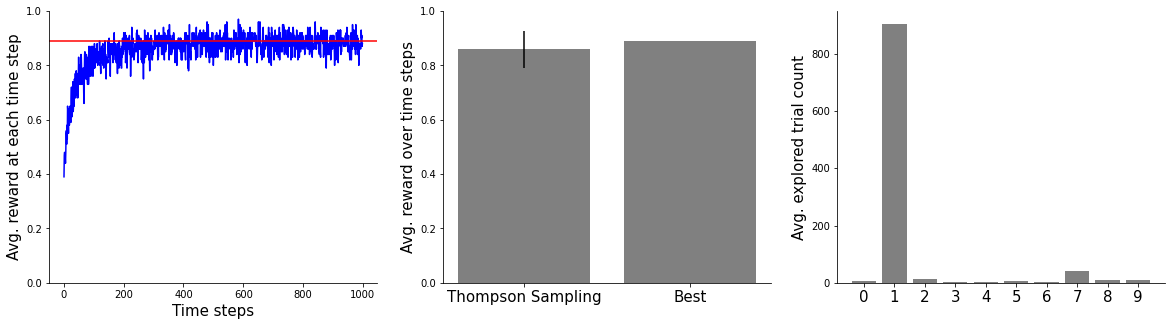

In [14]:
ts = ThompsonSampling(num_arm, reward_probs)
avg_rewards_ts, std_rewards_ts, avg_explored_cnt_ts, std_explored_cnt_ts = ts.run_iteration(num_ite, num_trial)
ts.plot_algorithm_performance('Thompson Sampling', avg_rewards_ts, std_rewards_ts, avg_explored_cnt_ts, num_trial, reward_probs[best_arm_index])
print(f"Avg.reward={np.round(np.mean(avg_rewards_ts),3)}")


One advantage of Thompson sampling is its ability to incorporate prior knowledge. By providing a well-informed prior to the algorithm, it can learn the optimal action more efficiently. Let's examine how the choice of prior influences the algorithm's performance. In this context, I will compare three scenarios:

1. Uniform prior
2. Good prior with many successful experiences with arm1 (i.e. the best arm)
3. Poor prior with limited successful experiences with arm1


In [15]:
prior1 = None # Uniform proir
prior2 = [[1,10],[10,1],[1,10],[1,10],[1,10],[1,10],[1,10],[1,10],[1,10],[1,10]] # Good prior
prior3 = [[10,1],[1,10],[10,1],[10,1],[10,1],[10,1],[10,1],[10,1],[10,1],[10,1]] # Bad prior


The best prior is prior1 with avg. reward=0.891


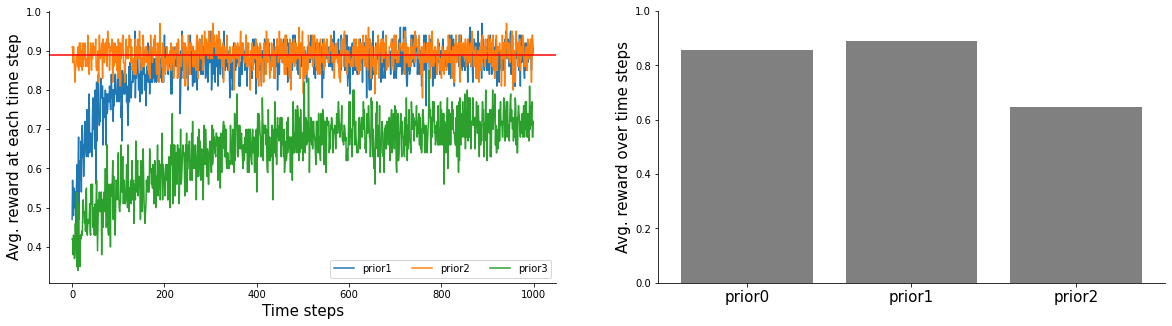

In [16]:
priors = [prior1, prior2, prior3]
avg_rewards_hist_ts = []
avg_rewards_overall_ts = []

# Iterate through different priors
for prior in priors:
    ts = ThompsonSampling(num_arm, reward_probs, prior)
    avg_rewards_ts, std_rewards_ts, avg_explored_cnt_ts, std_explored_cnt_ts = ts.run_iteration(num_ite, num_trial)
    avg_rewards_hist_ts.append(avg_rewards_ts)
    avg_rewards_overall_ts.append(np.mean(avg_rewards_ts))
    

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
label_str = []

# Plot average rewards for each prior
for i in range(len(priors)):
    plt.plot(list(range(num_trial)), avg_rewards_hist_ts[i], label=f"prior{i+1}")
    label_str.append(f"prior{i}")

plt.legend(ncol=3)
plt.axhline(y=reward_probs[best_arm_index], color='r')
plt.xlabel('Time steps', fontsize=fontsize)
plt.ylabel('Avg. reward at each time step', fontsize=fontsize)

plt.subplot(1, 2, 2)

# Create a bar chart to display overall average rewards for each prior
plt.bar(label_str, avg_rewards_overall_ts, color='gray')
plt.ylim([0, 1])
plt.xticks(fontsize=fontsize)
plt.ylabel('Avg. reward over time steps', fontsize=fontsize)

# Find the best prior based on the highest overall average reward
best_param_index = np.where(avg_rewards_overall_ts == np.max(avg_rewards_overall_ts))[0][0]
print(f"The best prior is {label_str[best_param_index]} with avg. reward={np.round(avg_rewards_overall_ts[best_param_index], 3)}")


A good prior (prior2) assists the algorithm in focusing on the best arm from the beginning, leading to optimal performance. In contrast, a poor prior (prior3) faces challenges in correcting initial misconceptions, resulting in a longer time to discover promising arms. This outcome underscores the significance of prior knowledge. However, it's worth noting that the algorithm performs equally well, even with a uniform prior, compared to other algorithms I've introduced thus far. Thus, Thompson sampling is useful algorithm for balancing exploitation and exploration, even in the absence of prior knowledge. Moreover, if prior knowledge is available, the algorithm's performance can be further enhanced.


## Reference

- Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.
- Russo, D. J., Van Roy, B., Kazerouni, A., Osband, I., & Wen, Z. (2018). A tutorial on thompson sampling. Foundations and Trends® in Machine Learning, 11(1), 1-96.